In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
from pandas import read_csv

john = read_csv("johnmayer_final.csv")
john = john.drop(john.columns[[0]], axis = 1)

## Data Cleaning Portion

In [4]:
from datetime import timedelta
import pandas as pd

# convert miliseconds to mm:ss notation
john['duration'] = john['duration'] / 1000
john['duration'] = pd.to_datetime(john["duration"], unit='s').dt.strftime("%M:%S")

In [5]:
# convert all "As/Is" albums to just be the same album name (As/Is)

john['album_name'] = john['album_name'].replace(to_replace='(As\SIs.+)', value='As/Is', regex=True)

# remove duplicate songs due to the As/Is combination
john['name'] = john['name'].drop_duplicates(keep='first', inplace=False)
john = john.dropna()


In [6]:
# impute values for song that didn't read in properly

import warnings
warnings.filterwarnings('ignore')

# convert 0's to NANs to replace easier
john['danceability'].replace(0, np.nan, inplace=True)
john['valence'].replace(0, np.nan, inplace=True)
john['tempo'].replace(0, np.nan, inplace=True)

fill_mean = lambda g: g.fillna(g.mean()) # fill NA values using group means

john = john.groupby('album_name').apply(fill_mean)

# check
john[john['name'] == 'On The Way Home'] 

,name,album_name,release_date,popularity,duration,danceability,valence,tempo,key,acousticness
32,On The Way Home,Paradise Valley,2013-08-20,45,03:59,0.6213,0.5714,123.6676,D,0.618


In [7]:
# drop singles that aren't from albums

john = john.drop(john.index[[177, 178, 179]])

In [8]:
# shorten the album name to just "Where the Light Is" so it shows up better on viz

john['album_name'] = john['album_name'].replace(to_replace='(Where.+)', value='Where The Light Is', regex=True)

## spot for another written save if necessary
#john.to_csv()

## Data Exploration & Visualization

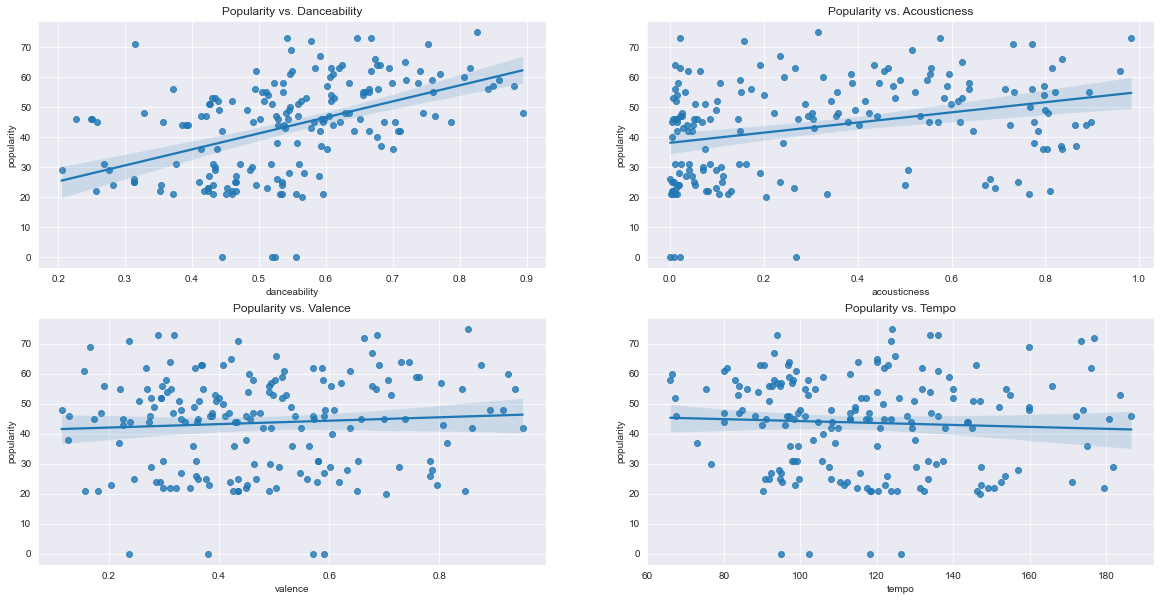

In [151]:
sns.set_style('darkgrid')
f, axs = plt.subplots(2, 2)
sns.regplot(ax=axs[0, 0], x = 'danceability', y = 'popularity', data = john).set(title = 'Popularity vs. Danceability')
sns.regplot(ax=axs[0, 1], x = 'acousticness', y = 'popularity', data = john).set(title = 'Popularity vs. Acousticness')
sns.regplot(ax=axs[1, 0], x = 'valence', y = 'popularity', data = john).set(title = 'Popularity vs. Valence')
sns.regplot(ax=axs[1, 1], x = 'tempo', y = 'popularity', data = john).set(title = 'Popularity vs. Tempo')

plt.rcParams['figure.figsize'] = [20, 10]
plt.show()

In [149]:
fig = px.scatter(data_frame = john, x = 'danceability', y = 'popularity', hover_data = john, color = 'album_name')
fig.update_layout(
    title={
        'text': "Popularity vs. Danceability, sorted by Album",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

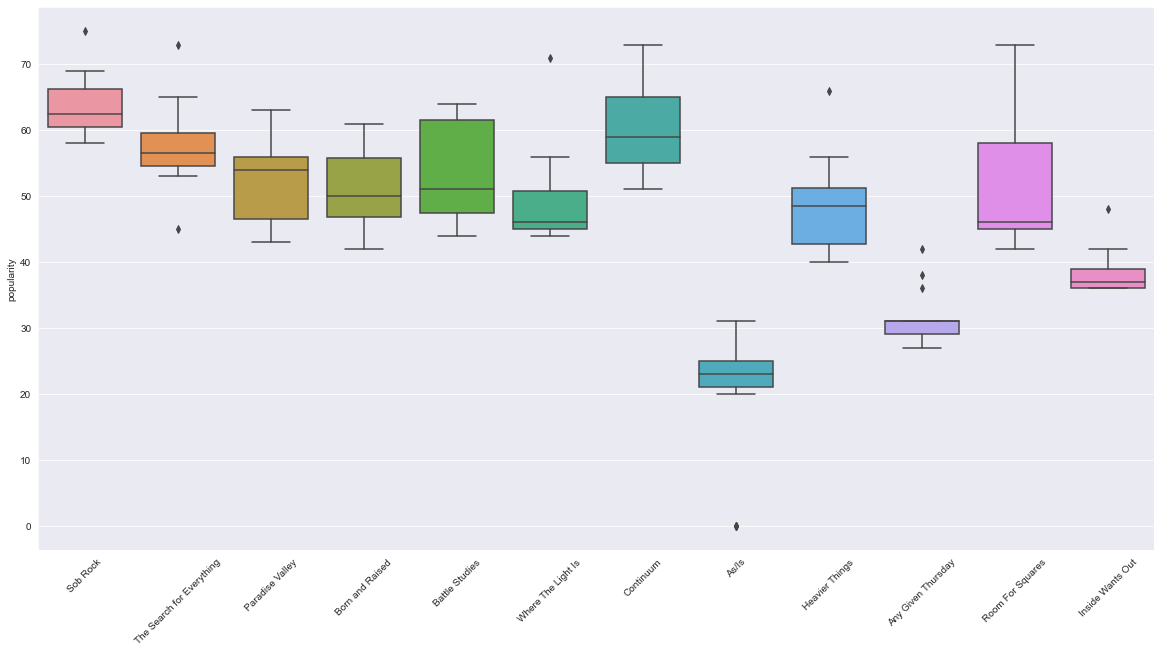

In [152]:
sns.set_style('darkgrid')
sns.boxplot(x = john['album_name'], y = john['popularity'])
plt.xlabel('')
plt.rcParams['figure.figsize'] = [30, 10]  
plt.xticks(rotation = 45)
plt.show()

# Room for squares, continuum, and sob rock have highest popularity scores

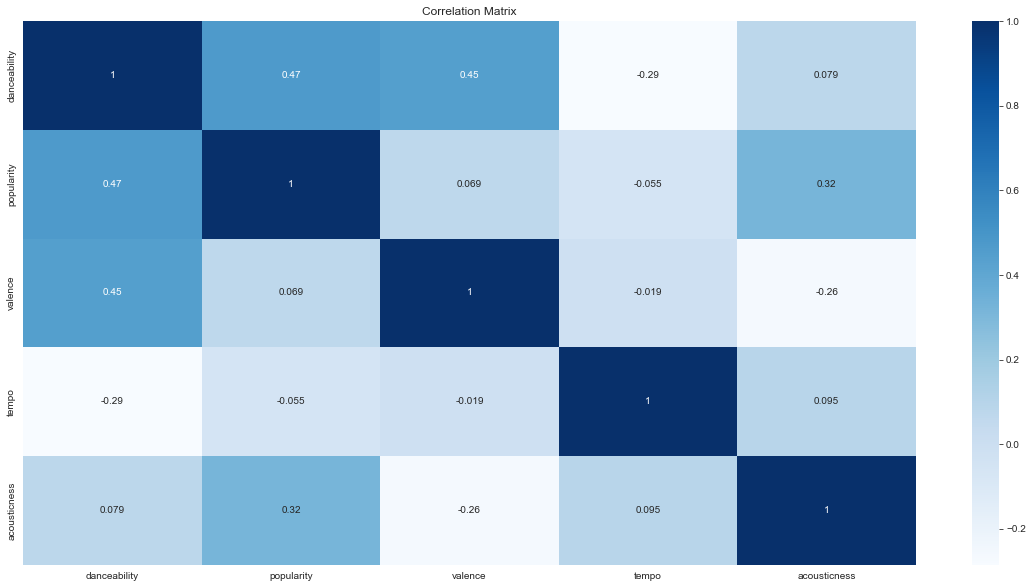

In [154]:
sns.heatmap(john[['danceability', 'popularity', 'valence', 'tempo', 'acousticness']].corr(), annot=True, cmap = 'Blues')
plt.title("Correlation Matrix")
plt.rcParams['figure.figsize'] = [10, 5]  
plt.show()

# decently positive relationships between danceability and popularity, danceability and valence
# decent positive relationship between popularity and acousticness too
# interesting negative relationship between danceability and tempo (as dancability increases, tempo decreases)
# interesting negative relationship between valence and acousticness (the more acoustic, the less positive the song is)

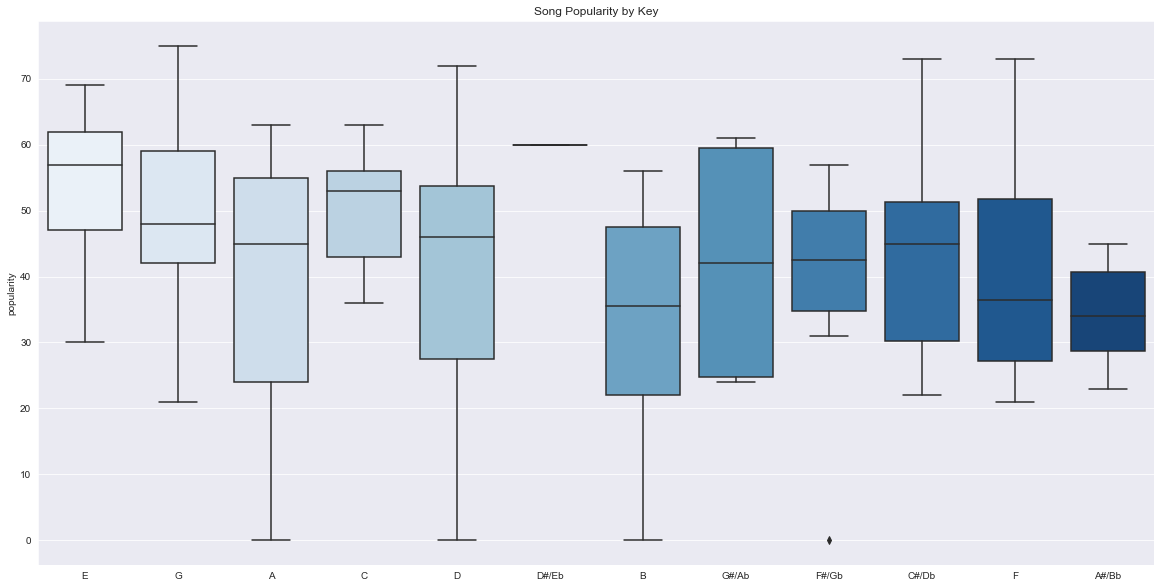

In [118]:
sns.set_style('darkgrid')
sns.boxplot(x = john['key'], y = john['popularity'], palette="Blues")
plt.xlabel('')
plt.rcParams['figure.figsize'] = [20, 10]  
plt.title("Song Popularity by Key")
plt.show()

# most popular songs are in the key of "G"

In [171]:
# Most popular songs based on key

key = john.groupby(['key'])['popularity'].max()

# key = key[['name', 'album_name', 'key', 'popularity']]

key


key
A        63
A#/Bb    45
B        56
C        63
C#/Db    73
D        72
D#/Eb    60
E        69
F        73
F#/Gb    57
G        75
G#/Ab    61
Name: popularity, dtype: int64

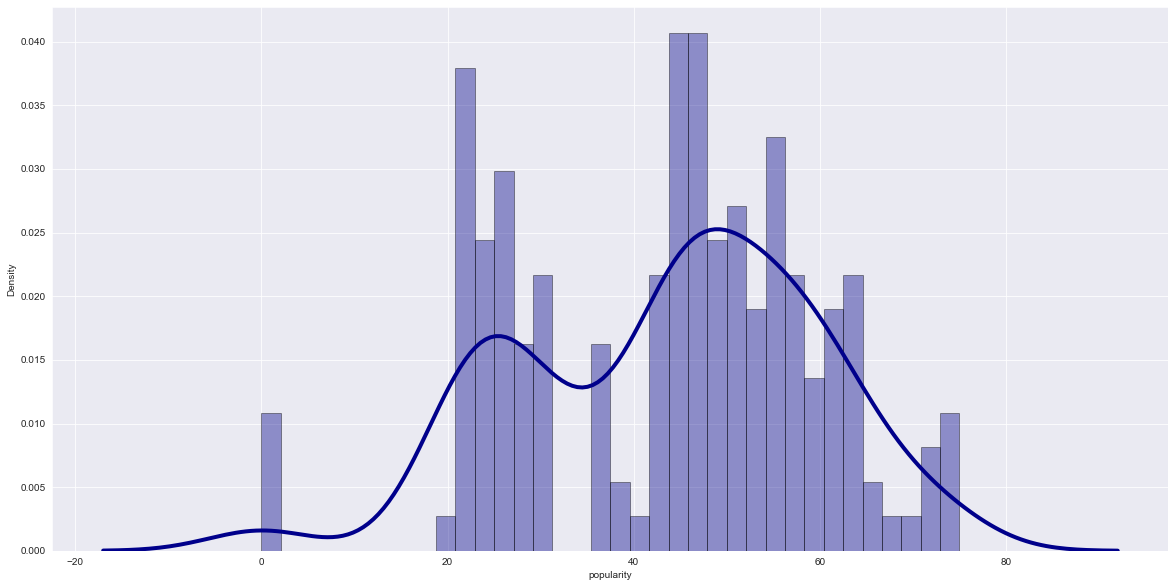

In [156]:
sns.distplot(john['popularity'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.rcParams['figure.figsize'] = [20, 10]  
      

In [138]:
import statsmodels.api as sm

#define response variable
y = john['popularity']

#define predictor variables
x = john[['danceability', 'tempo', 'valence', 'acousticness']]

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     19.07
Date:                Fri, 18 Nov 2022   Prob (F-statistic):           5.33e-13
Time:                        20:48:20   Log-Likelihood:                -708.46
No. Observations:                 177   AIC:                             1427.
Df Residuals:                     172   BIC:                             1443.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            6.9379      7.042      0.985   

In [166]:
john['popularity'].mean()

43.666666666666664

In [178]:
# Most popular songs based on key

names = john.groupby(['key'])['key', 'popularity', 'name', 'album_name']

# key = key[['name', 'album_name', 'key', 'popularity']]

names.head()


,key,popularity,name,album_name
0,E,67,Last Train Home,Sob Rock
1,E,62,Shouldn't Matter but It Does,Sob Rock
2,G,75,New Light,Sob Rock
3,A,58,Why You No Love Me,Sob Rock
4,C,63,Wild Blue,Sob Rock
5,D,62,Shot in the Dark,Sob Rock
6,E,69,I Guess I Just Feel Like,Sob Rock
7,D#/Eb,60,Til the Right One Comes,Sob Rock
8,E,64,Carry Me Away,Sob Rock
9,C,58,All I Want Is to Be With You,Sob Rock
